# Tutorial: Basics

This tutorial shows how to perform a multipole inversion from a magnetic scan surface into one or more magnetic sources that are represented as physical point sources. The `multipole_inversion` library contains two main classes to perform the numerical inversions:

- `MultipoleInversion` from the `multipole_inversion.multipole_inversion` library
- `MagneticSample` from the `multipole_inversion.magnetic_sample` library

With the `MagneticSample` module it is possible to define the scan grid dimensions and the location of the magnetic sources. From this class we save this information in `json` and `npz` files that can be inputted into the `MultipoleInversion` class. Both of these classes have extensive docstrings that can be read in this notebook for more information on the input parameters/arguments.

Additional tools include plotting functions defined in the class libraries or in the `multipole_inversion.plot_tools` module.

## Import and definitions

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from palettable.cartocolors.diverging import Geyser_5
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib as imp  # to reload libraries if implementing new features

In [24]:
# Load the libraries for the calculation of dipole fields
import multipole_inversion as minv
from multipole_inversion import MultipoleInversion
from multipole_inversion import MagneticSample
# import multipole_inversion.multipole_inversion as minv_mpi
import multipole_inversion.magnetic_sample as msp
import multipole_inversion.plot_tools as mpipt

In [12]:
# Define a colorbar for the plots
def colorbar(mappable, ax=None, location='right', size='5%', pad=0.05,
             orientation='vertical', ticks_pos='right', **kwargs):
    """
    Note: append_axes() reduces the size of ax to make room for the colormap
    ticks_pos       :: if orientation is vertical -> 'right' or 'left'
                       if orientation is horizontal -> 'top' or 'bottom'
    """

    if not ax:
        ax = plt.gca()

    # fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(location, size=size, pad=pad)
    # cbar = fig.colorbar(mappable, cax=cax)
    cbar = plt.colorbar(mappable, cax=cax, orientation=orientation,
                        **kwargs)
    if orientation == 'vertical':
        cax.yaxis.set_ticks_position(ticks_pos)
    elif orientation == 'horizontal':
        cax.xaxis.set_ticks_position(ticks_pos)
    # plt.sca(ax)
    return cbar

An example of docstring for the MultipoleInversion class:

In [ ]:
MultipoleInversion?

## Testing the dipole field function

Here we are testing the dipole field from the `dipole.py` library. We set the dipole as close to the origin as possible, and oriented in the $\hat{x}$ direction.

In [14]:
dip_r = np.array([[0., 0., -1e-10]])
dip_m = np.array([[1, 0., 0.]])

In [15]:
# we set the space grid in the -1,1 range in both x and y directions
x = np.linspace(-1, 1, 150)
X, Y = np.meshgrid(x, x)
positions = np.column_stack([X.ravel(), Y.ravel(), np.zeros_like(X.ravel())])

In [16]:
# Bz = msp.dipole_Bz(dip_r, dip_m, positions)
B = msp.dipole_field(dip_r, dip_m, positions)

We can now plot the dipole field around the origin, isolines are plotted for the $B_z$ component

(-0.085, 0.085)

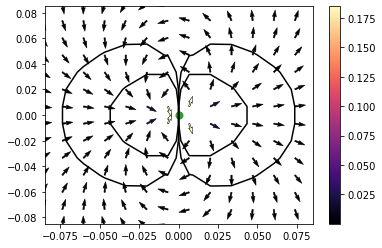

In [17]:
plt.contour(X, Y, B[:, 2].reshape(-1, len(x)),
            levels=[-1e-11, -1e-12, 1e-12, 1e-11],
            colors='k', linestyles='-')
# plt.contourf(X, Y, B[:, 1].reshape(-1, len(x)).T)

# Normalise arrows
U, V = B[:, 0], B[:, 1]
norm = np.sqrt(U ** 2 + V ** 2)
# print(norm)
U, V = U / norm, V / norm

p = plt.quiver(positions[:, 0], positions[:, 1], U, V, norm, scale=25,
               cmap='magma', width=.005, edgecolor='k', linewidth=.5)
plt.colorbar(p)

plt.scatter(dip_r[:, 0], dip_r[:, 1], c='C2', s=50)
plt.xlim(-0.085, 0.085)
plt.ylim(-0.085, 0.085)

The same using streamlines:

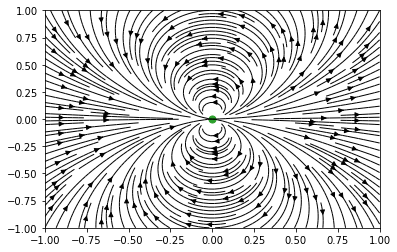

In [18]:
# Normalise arrows
U, V = B[:, 0], B[:, 1]

plt.streamplot(X, Y, B[:, 0].reshape(-1, len(x)), B[:, 1].reshape(-1, len(x)),
               density=2, linewidth=1, color='k')

plt.scatter(dip_r[:, 0], dip_r[:, 1], c='C2', s=50)
# plt.xlim(-0.085, 0.085)
# plt.ylim(-0.085, 0.085)

## Inversion of a single dipole source

In this Section we test the inversion of the field flux of a single dipole measured at a surface located at $H_z$ above a $Lx\times Ly\times Lz$ rectangular sample region, which contains the sipole at its centre.

In [20]:
Hz = 2e-6  # Scan height in m
Sx = 20e-6  # Scan area x - dimension in m
Sy = 20.1e-6  # Scan area y - dimension in m
Sdx = 0.1e-6  # Scan x - step in m
Sdy = 0.1e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 5e-6  # Sample thickness in m

# Initialise the dipole class
sample = MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)

# Generate two random particles in the sample region, which we are going to
# redefine (this might not be necessary, we need to add more methods to the class)
# sample.generate_particles(N_particles=1)

# Manually set the positions and magnetization of the two dipoles
Ms = 4.8e5
dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5, -sample.Lz * 0.5]])
magnetization = Ms * (1 * 1e-18) * np.array([[1., 0., 0.]])
volumes = np.array([1e-18])
sample.generate_particles_from_array(dipole_positions, magnetization, volumes)

print('Magnetization:', sample.dipole_moments)

# Generate the dipole field measured as the Bz field flux through the
# measurement surface
sample.generate_measurement_mesh()

Magnetization: [[4.8e-13 0.0e+00 0.0e+00]]


We can visualise the field generated by the dipole at the measurement surface. The colormap refers to the $B_z$ flux, and we add a streamplot to observe the dipole field direction $(B_x, B_y)$ at the surface.

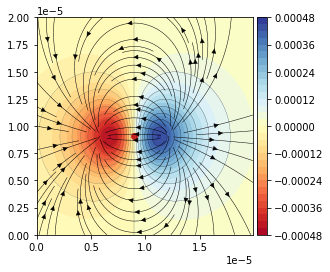

In [21]:
f, ax = plt.subplots()
cf, c1, c2 = sample.plot_sample(ax)
colorbar(cf)
ax.set_aspect('equal')
c2.set_color('C3')

# Streamplot: take the measurement surface range and generate a regular
# rectangular mesh grid. We take these mesh points to compute the field in them
x, y = sample.Sx_range, sample.Sy_range
X, Y = np.meshgrid(x, y)
positions = np.column_stack([X.ravel(), Y.ravel(), sample.Hz * np.ones_like(X.ravel())])
B = msp.dipole_field(sample.dipole_positions, sample.dipole_moments, positions)
# Generate random seed points from where streamlines emerge (density not
# necessary if random seeds are used)
seed_points_x = sample.Lx * np.random.random(150)
seed_points_y = sample.Ly * np.random.random(150)
ax.streamplot(X, Y,
              B[:, 0].reshape(-1, len(x)),
              B[:, 1].reshape(-1, len(x)),
              density=1.5, linewidth=0.5, color='k',
              start_points=np.column_stack((seed_points_x, seed_points_y)),
              # start_points=[[0, 0]],
               )
# plt.xlim(5e-6, 15e-6)
# plt.ylim(5e-6, 15e-6)

In [22]:
sample.save_data(filename='dipole_y-orientation')

Now we use the `inv_quadrupole.py` library to load the dipole field data and inverse the signal into the particle position, which gives us the dipole and quadrupole moments. The latter should be close to zero.

In the plot we observe that the inverte dsignal reproduces the original field accurately.

Scanning array size = 200 x 201
Generating forward matrix
Generation of Q matrix took: 0.1238 s
Using scipy.linalg.pinv2 for inversion


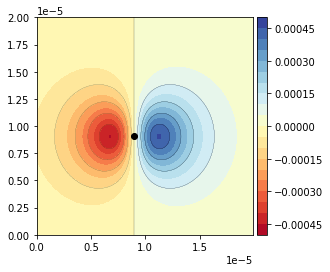

In [23]:
qinv = MultipoleInversion('./MetaDict_dipole_y-orientation.json',
                          './MagneticSample_dipole_y-orientation.npz')
qinv.compute_inversion(method='sp_pinv2')

f, ax = plt.subplots()
cf, c1, c2 = minv_mpi.plot_inversion_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

We can also check the residual is small compared to the inverted field:

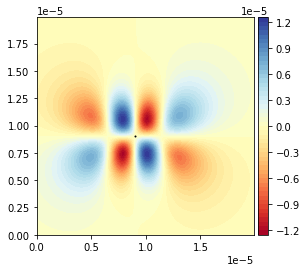

In [94]:
f, ax = plt.subplots()
cf, c1 = minv_mpi.plot_difference_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

The inverted magnetic moments (3 dipole moments and 5 quadrupole moments) shows us the original dipole moment in the $x$-direction. The other moments are significantly small with respecto to $m_x$

In [100]:
qinv.inv_multipole_moments

array([[ 8.19900901e-17,  3.99570646e-17, -6.61299707e-19,
        -2.08881684e-24,  1.37917152e-18, -2.27255428e-22,
        -3.45930320e-25, -1.11141388e-22]])

# Quadrupole

Here we define a quadrupole by specifying two magnetic dipoles oriented in opposite directions and located close to the center of the sample. Before saving the data, we redefine the two dipoles as a single particle at the center of the sample. The purpose of this idea is to analyse the strength of a magnetic quadrupole when solving the inversion problem. Accordingly, the dipole moments should be  close to zero and one or more quadrupole moments should be stronger.

## Quadrupole y-direction

The first example is a quadrupole oriented in the $+\hat{y}$ and $-\hat{y}$ directions, located at 4.5 micrometers from the measurement surface of the sample.

In [84]:
Hz = 2e-6  # Scan height in m
Sx = 20e-6  # Scan area x - dimension in m
Sy = 20e-6  # Scan area y - dimension in m
Sdx = 0.1e-6  # Scan x - step in m
Sdy = 0.1e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 5e-6  # Sample thickness in m

# Initialise the dipole class
sample = MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)

# Manually set the positions and magnetization of the two dipoles
Ms = 4.8e5
dipole_positions = np.array([[sample.Lx * 0.5 - 1e-6, sample.Ly * 0.5, -sample.Lz * 0.5],
                             [sample.Lx * 0.5 + 1e-6, sample.Ly * 0.5, -sample.Lz * 0.5]])
magnetization = Ms * (1 * 1e-18) * np.array([[0., 1., 0], [0., -1, 0]])
volumes = np.array([1e-18, 1e-18])
sample.generate_particles_from_array(dipole_positions, magnetization, volumes)

# Generate the dipole field measured as the Bz field flux through the
# measurement surface
sample.generate_measurement_mesh()

In [85]:
# DEBUG:
# pos_r = np.array([sample.Sx_range[len(sample.Sx_range) // 2],
#                   sample.Sy_range[len(sample.Sy_range) // 2],
#                   sample.Hz])
# r = pos_r - sample.dipole_positions
# print(r)

Here we show the dipole field at the measurement surface, generated from the two dipoles in the sample region

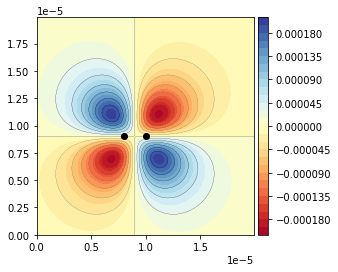

In [86]:
f, ax = plt.subplots()
cf, c1, c2 = sample.plot_sample(ax)
colorbar(cf)
ax.set_aspect('equal')

Now we redefine the `dipole_positions` in the `sample` instance in order to make a single quadrupole source rather than two dipoles:

In [ ]:
# Hack the positions array making a single particle at the centre
# (ideal quadrupole)
sample.dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5, -sample.Lz * 0.5]])
# This magnetisation direction should not matter (?)
sample.magnetization = Ms * (1 * 1e-18) * np.array([[0., 1., 0]])

# Update the N of particles to update the internal dict
sample.N_particles = 1

In [88]:
sample.save_data(filename='quadrupole_y-orientation')

In [ ]:
!cat MetaDict_dipole_y-orientation.json

At this point we can load the data for the inversion of the measurement generated in the previous steps, in the inversion code/class. Notice we are going to use the `maxwell_cartesian_polynomials` as a basis for the multipole expansion in order to physically interepret the results. Strictly, this basis is not orthogonal so it is not the most robust basis for the expansion. Nevertheless, for a single magnetic source it should solve the problem:

In [89]:
qinv = MultipoleInversion('./MetaDict_quadrupole_y-orientation.json',
                          './MagneticSample_quadrupole_y-orientation.npz',
                          expansion_limit='quadrupole',
                          sus_functions_module='maxwell_cartesian_polynomials')

{"Scan height Hz": 2e-06, "Scan area x-dimension Sx": 2e-05, "Scan area y-dimension Sy": 2.01e-05, "Scan x-step Sdx": 1e-07, "Scan y-step Sdy": 1e-07, "Time stamp": "20220111-153141", "Scan origin x": 0.0, "Scan origin y": 0.0, "Number of particles": 1}

In [91]:
qinv.compute_inversion(method='sp_pinv2')

Generating forward matrix
Generation of Q matrix took: 0.1252 s
Using scipy.linalg.pinv2 for inversion


We can compute the inverted measurement grid to compare it with the original measurement grid. We also notice we have now a single particle at the centre of the sample:

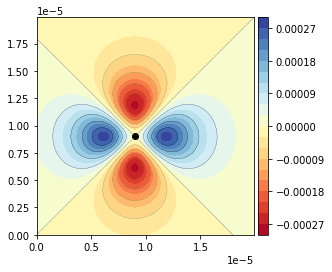

In [108]:
f, ax = plt.subplots()
cf, c1, c2 = minv_mpi.plot_inversion_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

From the inversion we can now check the magnitude of the inverted multipole moments. In this case, the inverted magnetization array is

$$
\texttt{inv magnetization} = [m_x, m_y, m_z, Q_1, Q_2, \ldots, Q_5]
$$

where $m_i$ are the dipole moments and $Q_i$ are the quadrupole moments.

In this example, we can see that $Q_2=Q_{xy}$ has the highest magnitude among the quadrupoles, and the magnitude is around $10^{-18}$ (check units). The dipole moments should be around $\approx 10^{-12}$ if we had only a dipolar field.

In [115]:
qinv.inv_multipole_moments

array([[ 3.98272091e-16, -3.98274465e-16, -3.70271025e-24,
         4.02755316e-29, -3.00112695e-21,  3.00111823e-21,
        -1.40708461e-22, -2.86881409e-29, -1.82924903e-34,
         8.03295201e-27, -8.03287308e-27,  5.19111200e-28,
         2.37243688e-35, -2.41482755e-27, -2.41482753e-27]])

And finally the difference between the measured field $B_z$ and the field from the inversion. The residual has an octupole character:

In [ ]:
f, ax = plt.subplots()
cf, c1 = minv_mpi.plot_difference_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

# Quadrupole x-direction

We repeat the same calculations here, but setting the two dipoles in the $x$-direction

In [95]:
Hz = 2e-6  # Scan height in m
Sx = 20e-6  # Scan area x - dimension in m
Sy = 20e-6  # Scan area y - dimension in m
Sdx = 0.1e-6  # Scan x - step in m
Sdy = 0.1e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 5e-6  # Sample thickness in m

sample = MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)
# Manually set positions
Ms = 4.8e5
dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5 - 1e-6, -sample.Lz * 0.5],
                             [sample.Lx * 0.5, sample.Ly * 0.5 + 1e-6, -sample.Lz * 0.5]])
magnetization = Ms * (1 * 1e-18) * np.array([[-1., 0., 0], [1., 0, 0]])
volumes = np.array([1e-18, 1e-18])
sample.generate_particles_from_array(dipole_positions, magnetization, volumes)

sample.generate_measurement_mesh()

In [ ]:
f, ax = plt.subplots()
p, *_ = sample.plot_sample(ax)
colorbar(p)

ax.set_aspect('equal')

In [ ]:
# Now hack the positions array making a single particle at the centre
# (ideal quadrupole)
sample.dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5, -sample.Lz * 0.5]])
# This magnetisation direction should not matter (?)
sample.magnetization = Ms * (1 * 1e-18) * np.array([[1., 0., 0]])

sample.N_particles = 1  # Need to modify the JSON file!

sample.save_data(filename='quadrupole_x-orientation')

In [98]:
minv.MultipoleInversion

multipole_inversion.multipole_inversion.MultipoleInversion

In [99]:
qinv = minv.MultipoleInversion('./MetaDict_quadrupole_x-orientation.json',
                               './MagneticSample_quadrupole_x-orientation.npz',
                               sus_functions_module='maxwell_cartesian_polynomials')
qinv.compute_inversion(method='sp_pinv2')

Scanning array size = 200 x 200
Generating forward matrix
Generation of Q matrix took: 0.1608 s
Using scipy.linalg.pinv2 for inversion


We again obtain the highest quadrupole for the $Q_{xy}$ component

In [10]:
qinv.inv_multipole_moments

array([[ 4.80000000e-13, -4.96982370e-29,  3.05190563e-29,
         6.30690805e-32, -7.56020189e-30,  1.51626272e-29,
         1.09320848e-29, -3.87921471e-29]])

## Quadrupole xy-direction

And the calculation for the dipoles in the $xy$ direction ($\phi = \pi/4$ in polar)

In [101]:
Hz = 2e-6  # Scan height in m
Sx = 20e-6  # Scan area x - dimension in m
Sy = 20e-6  # Scan area y - dimension in m
Sdx = 0.1e-6  # Scan x - step in m
Sdy = 0.1e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 5e-6  # Sample thickness in m

sample = msp.MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)
# Manually set positions
Ms = 4.8e5
dipole_positions = np.array([[sample.Lx * 0.5 - 1e-6, sample.Ly * 0.5 - 1e-6, -sample.Lz * 0.5],
                             [sample.Lx * 0.5 + 1e-6, sample.Ly * 0.5 + 1e-6, -sample.Lz * 0.5]])

n = np.sqrt(2)
magnetization = Ms * (1 * 1e-18) * np.array([[-1 / n, 1 / n, 0],
                                             [1 / n, -1 / n, 0]])
volumes = np.array([1e-18, 1e-18])
sample.generate_particles_from_array(dipole_positions, magnetization, volumes)

sample.generate_measurement_mesh()

In [ ]:
f, ax = plt.subplots()
p, *_ = sample.plot_sample(ax)
colorbar(p)

ax.set_aspect('equal')

In [ ]:
# Now hack the positions array making a single particle at the centre
# (ideal quadrupole)
sample.dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5, -sample.Lz * 0.5]])
# This magnetisation direction should not matter (?)
sample.magnetization = Ms * (1 * 1e-18) * np.array([[-1 / n, 1 / n, 0]])

sample.N_particles = 1

sample.save_data(filename='quadrupole_xy-orientation')

In [106]:
qinv = minv.MultipoleInversion('./MetaDict_quadrupole_xy-orientation.json',
                               './MagneticSample_quadrupole_xy-orientation.npz',
                               expansion_limit='quadrupole')
qinv.compute_inversion(method='sp_pinv2')

Scanning array size = 200 x 200
Generating forward matrix
Generation of Q matrix took: 0.1782 s
Using scipy.linalg.pinv2 for inversion


Now the highest moments are the $Q_{1}=Q_{11}=Q_{xx}$ and the $Q_{4}=Q_{22}=Q_{yy}$ components

In [93]:
qinv.inv_multipole_moments

array([[-3.99570646e-17, -8.19900901e-17,  6.61299707e-19,
         3.45930322e-25, -1.37917152e-18,  1.11141388e-22,
         2.08881684e-24,  2.27255428e-22]])

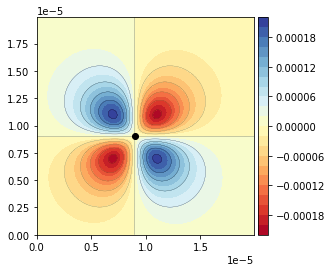

In [92]:
f, ax = plt.subplots()
cf, c1, c2 = minv_mpi.plot_inversion_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

# Octupole

In [109]:
Hz = 2e-6  # Scan height in m
Sx = 20e-6  # Scan area x - dimension in m
Sy = 20e-6  # Scan area y - dimension in m
Sdx = 0.1e-6  # Scan x - step in m
Sdy = 0.1e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 5e-6  # Sample thickness in m

sample = msp.MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)
# Manually set positions
Ms = 4.8e5
dipole_positions = np.array([[sample.Lx * 0.5 + 1e-6, sample.Ly * 0.5 + 1e-6, -sample.Lz * 0.5],
                             [sample.Lx * 0.5 - 1e-6, sample.Ly * 0.5 + 1e-6, -sample.Lz * 0.5],
                             [sample.Lx * 0.5 - 1e-6, sample.Ly * 0.5 - 1e-6, -sample.Lz * 0.5],
                             [sample.Lx * 0.5 + 1e-6, sample.Ly * 0.5 - 1e-6, -sample.Lz * 0.5]])

n = np.sqrt(2)
magnetization = Ms * (1 * 1e-18) * np.array([[-1 / n, 1 / n, 0],
                                             [-1 / n, -1 / n, 0],
                                             [1 / n, -1 / n, 0],
                                             [1 / n, 1 / n, 0]])
volumes = np.array([1e-18, 1e-18, 1e-18, 1e-18])
sample.generate_particles_from_array(dipole_positions, magnetization, volumes)

sample.generate_measurement_mesh()

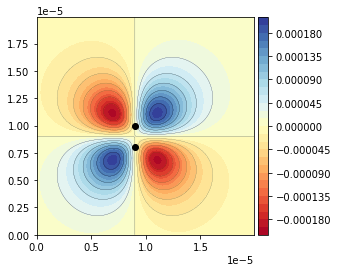

In [96]:
f, ax = plt.subplots()
p, *_ = sample.plot_sample(ax)
colorbar(p)

ax.set_aspect('equal')

In [97]:
# Now hack the positions array making a single particle at the centre
# (ideal octupole)
sample.dipole_positions = np.array([[sample.Lx * 0.5, sample.Ly * 0.5, -sample.Lz * 0.5]
                                    ])
# This magnetisation direction should not matter (?)
sample.magnetization = Ms * (1 * 1e-18) * np.array([[-1 / n, 1 / n, 0]])
sample.N_particles = 1 # Need to modify the JSON file!
sample.save_data(filename='octupole')

In [ ]:
# We could try to use 2 quadrupoles as well:

# # Now hack the positions array making a single particle at the centre
# # (ideal octupole)
# sample.dipole_positions = np.array([[sample.Lx * 0.5 + 1e-6, sample.Ly * 0.5 + 1e-6, -sample.Lz * 0.5],
#                                     [sample.Lx * 0.5 - 1e-6, sample.Ly * 0.5 - 1e-6, -sample.Lz * 0.5]
#                                     ])
# # This magnetisation direction should not matter (?)
# sample.magnetization = Ms * (1 * 1e-18) * np.array([[-1 / n, 1 / n, 0],
#                                                     [1 / n, -1 / n, 0]
#                                                     ])
# sample.N_particles = 2
# sample.save_data(filename='octupole')

In [ ]:
qinv = minv.MultipoleInversion('./MetaDict_octupole.json',
                               './MagneticSample_octupole.npz',
                               expansion_limit='octupole',
                               sus_functions_module='spherical_harmonics_basis'
                               )
qinv.compute_inversion(method='sp_pinv2', rcond=1e-20)

In [ ]:
f, ax = plt.subplots()
cf, c1, c2 = minv_mpi.plot_inversion_Bz(qinv, ax)
ax.set_aspect('equal')
colorbar(cf)

In [ ]:
f, ax = plt.subplots()
cf, c1 = minv_mpi.plot_difference_Bz(qinv, ax)
ax.set_aspect('equal')
colorbar(cf)

In [107]:
qinv.inv_multipole_moments

array([[ 5.40141200e-16, -5.40141200e-16, -1.11623818e-27,
         3.99028610e-33, -2.09919164e-21,  2.09919164e-21,
         2.64190432e-18, -6.30779673e-33]])

# Multiple particles sample

In [60]:
Hz = 5e-6  # Scan height in m
Sx = 200e-6  # Scan area x - dimension in m
Sy = 300e-6  # Scan area y - dimension in m
Sdx = 2e-6  # Scan x - step in m
Sdy = 3e-6  # Scan y - step in m
Lx = Sx * 0.9  # Sample x - dimension in m
Ly = Sy * 0.9  # Sample y - dimension in m
Lz = 30e-6  # Sample thickness in m

sample = msp.MagneticSample(Hz, Sx, Sy, Sdx, Sdy, Lx, Ly, Lz)

sample.generate_random_particles(seed=42)
# print(sample.dipole_positions)

sample.generate_measurement_mesh()
sample.save_data(filename='seed42')

In [61]:
sample.Bz_array.shape

(100, 100)

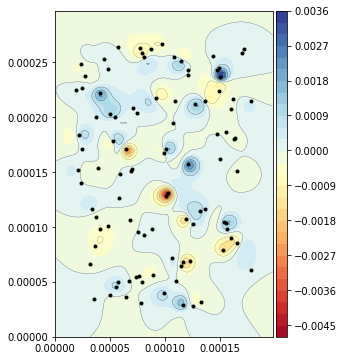

In [62]:
f, ax = plt.subplots(figsize=(6, 6))

cf, c1, c2 = sample.plot_sample(ax)
c2.set_sizes(c2.get_sizes() / 4)
colorbar(cf)
ax.set_aspect('equal')

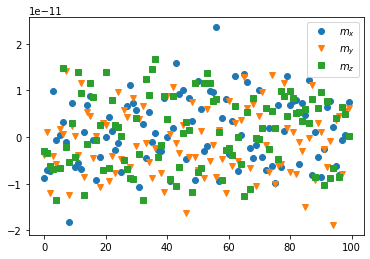

In [64]:
plt.plot(sample.dipole_moments[:, 0], 'o', label=r'$m_x$')
plt.plot(sample.dipole_moments[:, 1], 'v', label=r'$m_y$')
plt.plot(sample.dipole_moments[:, 2], 's', label=r'$m_z$')

plt.legend()

## Inversion

In [67]:
qinv = minv.MultipoleInversion('./MetaDict_seed42.json',
                               './MagneticSample_seed42.npz')

Scanning array size = 100 x 100


In [68]:
qinv.compute_inversion(rcond=1e-10, method='np_pinv')

Generating forward matrix
Generation of Q matrix took: 0.1362 s
Using numpy.pinv for inversion


In [69]:
qinv.inv_multipole_moments[:10]

array([[-1.00275998e-11, -1.09300851e-11,  4.00512722e-12,
        -4.48719881e-17,  1.30387186e-17,  5.43854815e-17,
         2.94773251e-17, -3.13438990e-18],
       [-6.96637232e-12,  1.06269115e-12, -3.33727444e-12,
         1.75709480e-20, -1.00402294e-19, -1.10267909e-19,
         4.81795828e-21, -8.00985351e-20],
       [-7.18369956e-12, -1.19192260e-11, -6.45404254e-12,
         1.77955007e-18, -4.55283323e-20,  6.92801264e-19,
         2.48954853e-18, -2.32297668e-19],
       [ 1.00804804e-11, -4.10555103e-12, -6.68273379e-12,
         3.81543650e-19, -2.92837410e-18, -7.16780224e-19,
        -8.76046910e-19,  9.35422667e-19],
       [-6.43159996e-13, -5.85191859e-12, -1.34308431e-11,
        -1.20492749e-20, -7.22959063e-22, -1.35847223e-20,
        -3.86753974e-21,  3.73398845e-21],
       [ 8.87989941e-13,  1.84399213e-12, -6.35868752e-12,
        -1.13144575e-18, -3.89993923e-18, -7.34105909e-19,
         7.48551326e-20,  1.67299612e-19],
       [ 2.46072772e-12,  1.225507

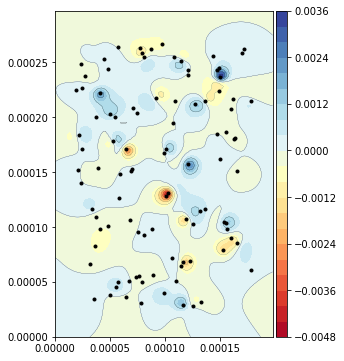

In [70]:
f, ax = plt.subplots(figsize=(6, 6))
cf, c1, c2 = minv_mpi.plot_inversion_Bz(qinv, ax)
c2.set_sizes(c2.get_sizes() / 4)
colorbar(cf)
ax.set_aspect('equal')

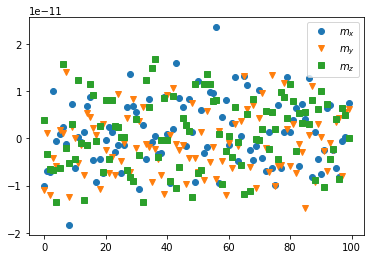

In [71]:
plt.plot(qinv.inv_multipole_moments[:, 0], 'o', label=r'$m_x$')
plt.plot(qinv.inv_multipole_moments[:, 1], 'v', label=r'$m_y$')
plt.plot(qinv.inv_multipole_moments[:, 2], 's', label=r'$m_z$')

plt.legend()

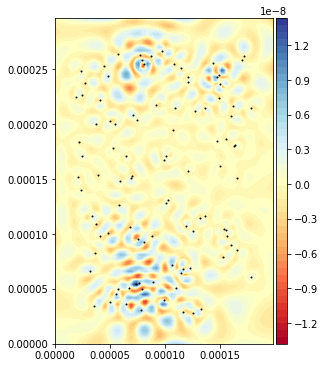

In [72]:
f, ax = plt.subplots(figsize=(6, 6))
cf, c1 = minv_mpi.plot_difference_Bz(qinv, ax)
colorbar(cf)
ax.set_aspect('equal')

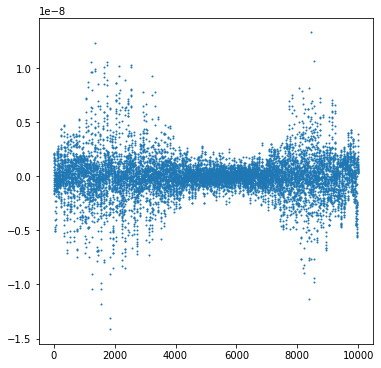

In [73]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot(qinv.Bz_array.flatten() - qinv.inv_Bz_array.flatten(),
        'o', label=r'$m_x$', ms=1)

In [74]:
print(f'B_z (max) = {np.max(qinv.Bz_array)}  | B_z (min) = {np.min(qinv.Bz_array)}')

B_z (max) = 0.0033845869641065352  | B_z (min) = -0.004771340039837247


In [75]:
# Residual root mean square
L = len(qinv.Bz_array.flatten())
Bzinv_minus_Bz = (qinv.Bz_array.flatten() - qinv.inv_Bz_array.flatten())
RRMS = np.sqrt(np.sum(Bzinv_minus_Bz ** 2)) / np.sqrt(L)
print(RRMS)

1.862340568030746e-09


In [76]:
NRRMS = RRMS / (Bzinv_minus_Bz.max() - Bzinv_minus_Bz.min())
print(f'Normalised RRMS: {NRRMS:.4f} %')

Normalised RRMS: 0.0679 %


Text(0, 0.5, '$m_{i}^{\\mathrm{predicted}} - m_{i}^{\\mathrm{data}}$')

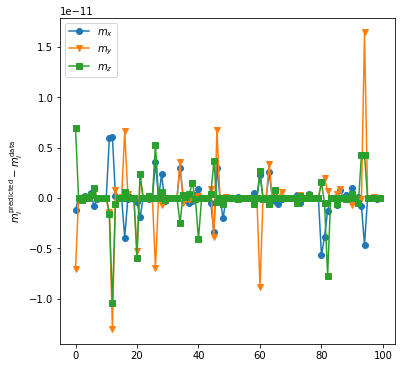

In [78]:
f, ax = plt.subplots(figsize=(6, 6))

ax.plot(qinv.inv_multipole_moments[:, 0] - qinv.dipole_moments[:, 0], 'o-', label=r'$m_x$')
ax.plot(qinv.inv_multipole_moments[:, 1] - qinv.dipole_moments[:, 1], 'v-', label=r'$m_y$')
ax.plot(qinv.inv_multipole_moments[:, 2] - qinv.dipole_moments[:, 2], 's-', label=r'$m_z$')

ax.legend()
ax.set_ylabel(r'$m_{i}^{\mathrm{predicted}} - m_{i}^{\mathrm{data}}$')